In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import optimizers


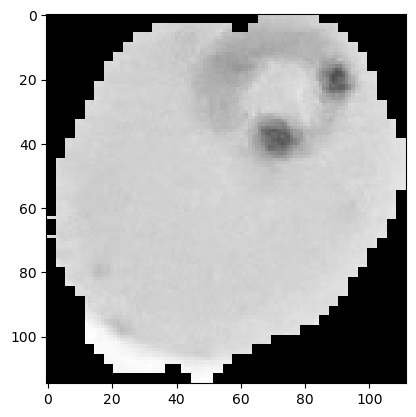

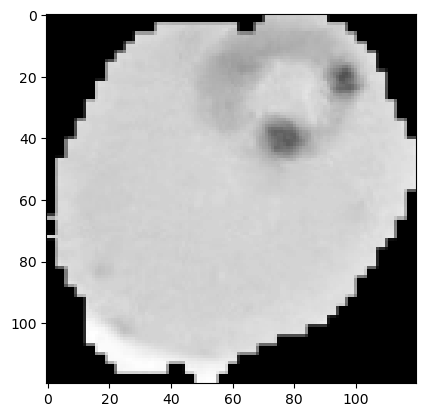

In [4]:
#view one sample of data

data_path = "/Users/josephzhai/Documents/Data_Projects/Detecting_Malaria/cell_images/cell_images"

cell_statuses = ["Parasitized", "Uninfected"]

for cell_status in cell_statuses:  
    path = os.path.join(data_path, cell_status)  # create path to each cell status
    for image in os.listdir(path):  # iterate over each image for each cell status
        image_array = cv2.imread(os.path.join(path,image) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(image_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  
    break  

image_size = 120

simplified_array = cv2.resize(image_array, (image_size, image_size))
plt.imshow(simplified_array, cmap='gray')
plt.show()



In [5]:
#Create Training Data Set

training_data = []

def construct_training_set():
    for cell_status in cell_statuses:  
        path = os.path.join(data_path,cell_status)  
        cell_status_classification = cell_statuses.index(cell_status) #set each cell_status into a number (its index)
        for image in os.listdir(path):  
            try:
                image_array = cv2.imread(os.path.join(path,image) ,cv2.IMREAD_GRAYSCALE)  
                simplified_array = cv2.resize(image_array, (image_size, image_size))
                training_data.append([simplified_array, cell_status_classification])
            except Exception as e:
                pass
            
construct_training_set()

In [6]:
#shuffle data since data is split in order (so NN can predict properly)

import random
random.shuffle(training_data)

In [7]:
#Train-test split

from sklearn.model_selection import train_test_split

X = [] #feature set
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, image_size, image_size, 1)


#Normalize Data (max is 255, min is 0 for pixel data)
X = X/255.0

y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(f'Training Data Shape : {X_train.shape}')
print(f'Test Data Shape : {X_test.shape}')

Training Data Shape : (22046, 120, 120, 1)
Test Data Shape : (5512, 120, 120, 1)


In [8]:
#building model

model = Sequential()


#layer 1
model.add(Conv2D(32, (3,3), input_shape = X_train.shape[1:])) #conv layer: 32 units, 3x3 window size, input shape
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

#layer 2
model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

#layer 3
model.add(Flatten())  #converts 3D feature maps to 1D feature vectors
model.add(Dense(64))  
model.add(Activation("relu"))
          
#output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

          
m = model.fit(X_train, y_train, batch_size=20, epochs=5, validation_split=0.1)

2023-01-09 16:55:44.056597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
993/993 [==============================] - 49s 49ms/step - loss: 0.6577 - accuracy: 0.6070 - val_loss: 0.6254 - val_accuracy: 0.6485
Epoch 2/5
993/993 [==============================] - 48s 49ms/step - loss: 0.5401 - accuracy: 0.7219 - val_loss: 0.3748 - val_accuracy: 0.8503
Epoch 3/5
993/993 [==============================] - 48s 48ms/step - loss: 0.2520 - accuracy: 0.9069 - val_loss: 0.1753 - val_accuracy: 0.9379
Epoch 4/5
993/993 [==============================] - 48s 48ms/step - loss: 0.1542 - accuracy: 0.9461 - val_loss: 0.1680 - val_accuracy: 0.9406
Epoch 5/5
993/993 [==============================] - 48s 48ms/step - loss: 0.1034 - accuracy: 0.9652 - val_loss: 0.1994 - val_accuracy: 0.9338


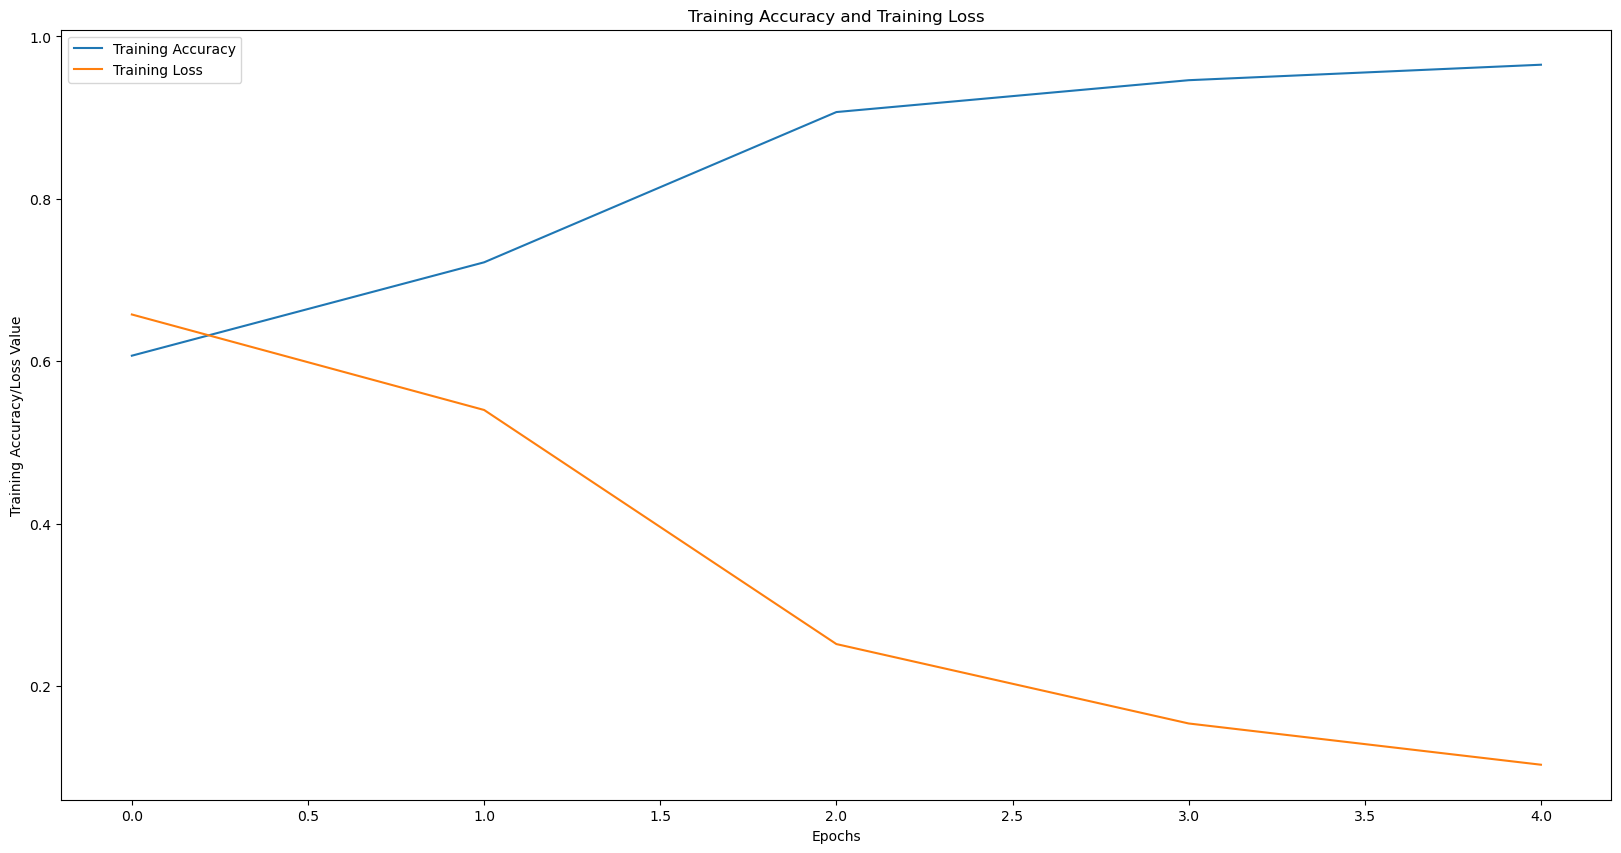

In [9]:
#graph model training accuracy and loss

plt.figure(figsize = (20,10))
plt.plot(range(5), m.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(5), m.history['loss'], label = 'Training Loss')

plt.xlabel("Epochs")
plt.ylabel('Training Accuracy/Loss Value')
plt.title('Training Accuracy and Training Loss')
plt.legend(loc = "best")

In [10]:
#Test model on test data

model_evaluation = model.evaluate(X_test, y_test)

print('model loss : ', model_evaluation[0])
print('model accuracy : ', model_evaluation[1])

173/173 [==============================] - 4s 22ms/step - loss: 0.1955 - accuracy: 0.9374
model loss :  0.19552046060562134
model accuracy :  0.9374092817306519


In [44]:
#Data Augmentation to improve model!

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=10)

datagen.fit(X_train)

aug_m = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32, shuffle = False), epochs=3)



Epoch 1/3


/var/folders/43/slx6dnq14yq5jrmrcfwvwhvw0000gn/T/ipykernel_28510/1529443000.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  aug_m = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32, shuffle = False), epochs=3)


689/689 [==============================] - 53s 77ms/step - loss: 0.1194 - accuracy: 0.9587
Epoch 2/3
689/689 [==============================] - 53s 77ms/step - loss: 0.1147 - accuracy: 0.9606
Epoch 3/3
689/689 [==============================] - 53s 77ms/step - loss: 0.1099 - accuracy: 0.9620


In [45]:
#Test new model on test data

#scores = model.evaluate_generator(datagen.flow(X_test, y_test, batch_size=32))
aug_model_eval = model.evaluate_generator(datagen.flow(X_test, y_test, batch_size=32))

print('model loss : ', aug_model_eval[0])
print('model accuracy : ', aug_model_eval[1])

/var/folders/43/slx6dnq14yq5jrmrcfwvwhvw0000gn/T/ipykernel_28510/1042038028.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  aug_model_eval = model.evaluate_generator(datagen.flow(X_test, y_test, batch_size=32))


model loss :  0.13988712430000305
model accuracy :  0.9548258185386658


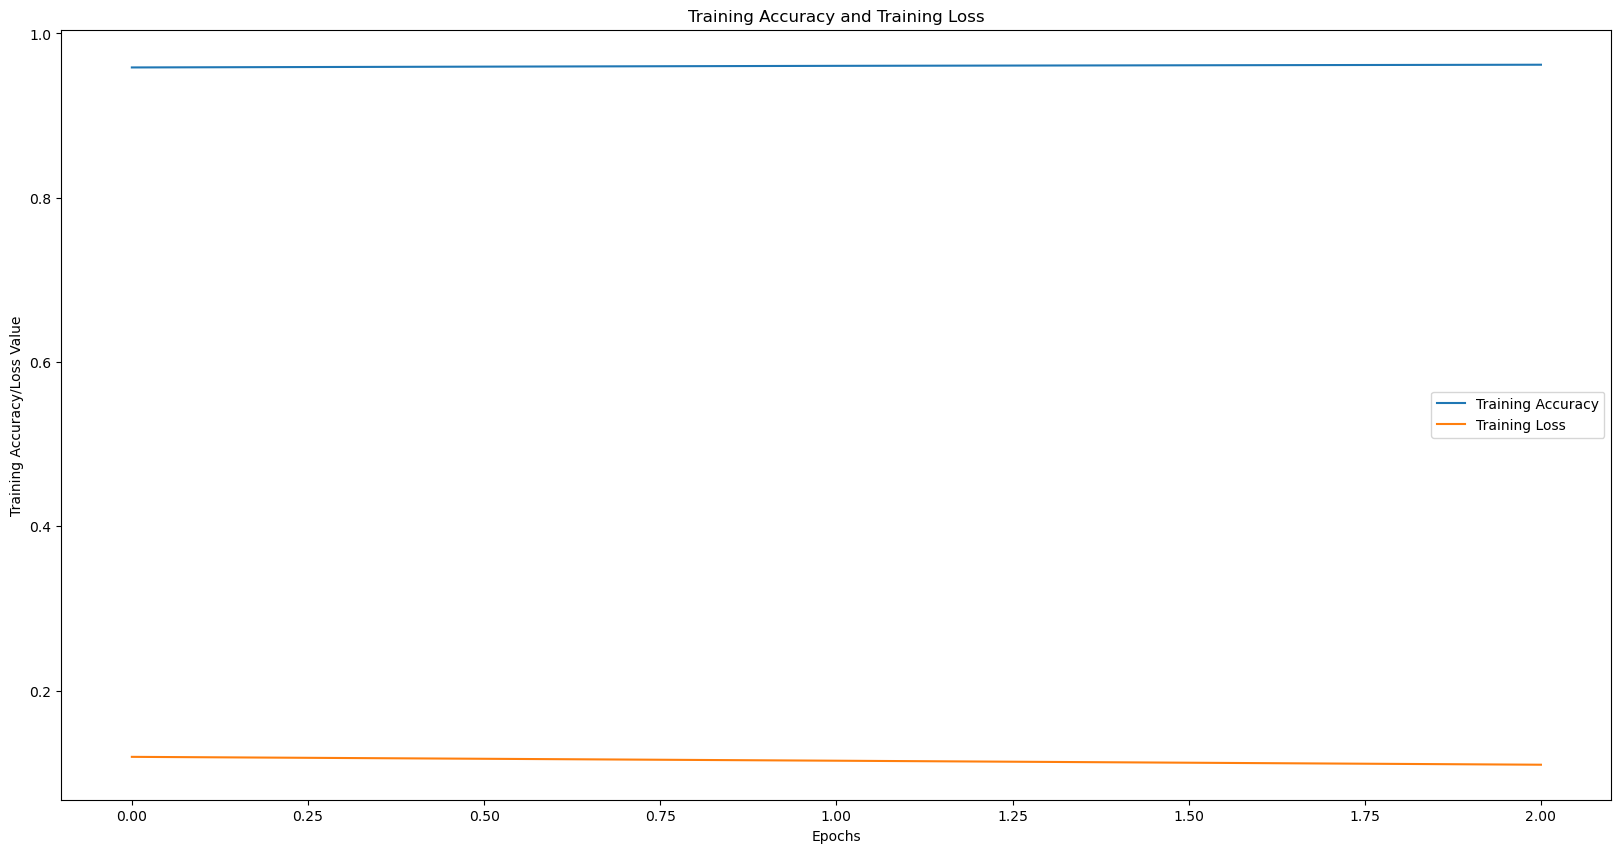

In [46]:
#graph new model training accuracy and loss

plt.figure(figsize = (20,10))
plt.plot(range(3), aug_m.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(3), aug_m.history['loss'], label = 'Training Loss')

plt.xlabel("Epochs")
plt.ylabel('Training Accuracy/Loss Value')
plt.title('Training Accuracy and Training Loss')
plt.legend(loc = "best")

#model plateaus after first epoch, sign of overfitting?